#### Author: Apurva Bhandari <apurvaasf7@gmail.com> & Devashish Deshpande <ashu.9412@gmail.com>

In [3]:
import re
import sys
import math
import numpy as np
from numpy import NaN, Inf, arange, isscalar, asarray, array, std
from matplotlib import pyplot as plt
from matplotlib import colors as cl
import operator
%matplotlib inline

In [4]:
"""Email yourself the whatsapp conversation. Place it in the same directory as this code.
   Change filename variable to whatever you've named your file.
"""
filename = raw_input("Enter filename with extension: ")

Enter filename with extension: asaku.txt


#### Import stopwords. Stopwords taken from Google stopwords dataset.

In [5]:
"""Purpose is to eliminate meaningless words such as 'the', 'a' etc. which might 
   spoil our analysis results.
"""
stopwords = []
for l in open('stop-words.txt'):
    stopwords.append(l.strip())

#### Tokenize

In [6]:
def tokenize(text):
    """ An implementation of input string tokenization that excludes stopwords
    
    Args:
        string (str): input string
        
    Returns:
        list: a list of tokens without stopwords
    """
    return filter(lambda s: s if s not in stopwords else '', re.split('\W+', text))

#### Removing punctuation

In [7]:
def removePunctuation(text):
    """Removes punctuation, changes to lower case, and strips leading and trailing spaces.

    Note:
        Only spaces, letters, and numbers should be retained.  Other characters should should be
        eliminated (e.g. it's becomes its).  Leading and trailing spaces should be removed after
        punctuation is removed.

    Args:
        text (str): A string.

    Returns:
        str: The cleaned up string.
    """
    string = re.sub('[^a-zA-Z\d\s]+', '', text)
    return string.lower().strip(' ')

#### Splitting data up

In [8]:
def splitData(line):
    """Parses the line to return the individual components of it.
    TODO: Make it compatible with USA, China etc. date formats.
    
    Args:
        line (str): Line of the form eg. '17/07/2015, 10:25 AM - (some string)'
        Note that (some string) need not be of the form 'Name: Message'. Could be something like 'You were added'.
        
    Returns:
        date: Date of message.
        hour: Hour of message.
        minute: Minute of message.
        name: Name of texter.
        text: Text of message.
    """
    try:
        timestamp, string = line.split('-', 1)
    except ValueError:
        print(line)
    date, time = map(lambda x: x.strip(), timestamp.split(','))
    
    # In many convos, the time is already in 24 Hr format. This is handled here.
    if 'AM' in time or 'PM' in time:
        hour, minmeridiem = time.split(':')
        minute, meridiem = minmeridiem.split()
        # Converting hours to 24 Hr format.
        if meridiem == 'AM' and int(hour) == 12:
            hour = int(hour) - 12
        elif meridiem == 'PM' and int(hour) != 12:
            hour = int(hour) + 12
        else:
            hour = int(hour)
    else:
        hour, minute = map(lambda l: int(l), time.split(':'))
        
    # Handling strings of the form:
    # 17/07/2015, 10:25 AM - You were added
    # or
    # 17/07/2015, 10:25 AM - Name created group “Group 1”
    try:
        name, text = map(lambda x: x.strip(), string.split(':', 1))
        # Handling unsaved numbers.
        if '\xe2\x80\xaa' in name:
            name=re.findall('\+[0-9 ]+', name)[0]
    except ValueError as e:
        name = ''
        text = string.strip()
    # for media files
    if '<Media omitted>' in text:
        text='<Media omitted>'
    else:
        text = removePunctuation(text) # Problem might arise during sentiment analysis. Emoticons might be needed.
    return (date, hour, minute, name, text)

#### Let's start

In [9]:
# Reqd dictionaries to maintain track of each message.
date = {}
hour = {}
minute = {}
name = {}
text = {}
# and a list
words = []
multimedia = 0 # count of mulimedia messages.
i=0 # Essentially a message id. Primary key to address all attributes
for l in open(filename):
    if re.search('\d+/\d+/\d+, \d+:\d+',l) is not None:
        splitData(l)
        try:
            date[i], hour[i], minute[i], name[i], text[i] = splitData(l)
            if text[i] == '<Media omitted>':
                multimedia += 1
                text[i] = '123456789media_omitted123456789' # my little media message identification.
        except ValueError:
            print(l)
        i += 1
    else:
        # Missing timestamp. Is a multiline message. Append to last texter's text. Will have to keep same timestamp
        string = removePunctuation(l)
        try:
            text[i-1]+=' '+string
        except KeyError as e:
            print("error")
        words.extend(tokenize(string))

assert len(date) == len(name), 'Some problem in parsing'

print("No of messages we're analysing: %d \nNo of multimedia messages: %d" %(len(date),multimedia))
# Tokenize rest of the text.
for k in text.keys():
    words.extend(tokenize(text[k]))

No of messages we're analysing: 11324 
No of multimedia messages: 332


#### Some stuff with words

In [15]:
words_dict = {}
for w in words:
    if w in words_dict:
        words_dict[w]+=1
    else:
        words_dict[w]=1
del words_dict['123456789media_omitted123456789']

#### It. Is. Plotting time.

In [ ]:
plt.plot(words_dict.values(),color='blue')
plt.xlabel('Words')
plt.ylabel('Frequency')
_ = plt.xticks([])

In [ ]:
sorted_words_list = sorted(words_dict.items(), key=operator.itemgetter(1), reverse=True)
print 'Top 20 most used words:'
for i in range(20):
    print '{0} : {1}' .format(sorted_words_list[i][0], sorted_words_list[i][1])

#### Peak detection using sliding window

In [ ]:
# source: https://gist.github.com/endolith/250860
def peakdet(v, delta, x = None):
    """Implementation of peak detection using sliding window. 
    
    Args: 
        v: 1-D data.
        delta: Difference we want between peaks.
          
    Returns:
        maxtab: np.array of peaks.
        mintab: np.array of minimas. (Won't have any in our case.)
    """
    maxtab = []
    mintab = []
       
    if x is None:
        x = arange(len(v))
    
    v = asarray(v)
    
    if len(v) != len(x):
        sys.exit('Input vectors v and x must have same length')
    
    if not isscalar(delta):
        sys.exit('Input argument delta must be a scalar')
    
    if delta <= 0:
        sys.exit('Input argument delta must be positive')
    
    mn, mx = Inf, -Inf
    mnpos, mxpos = NaN, NaN
    
    lookformax = True
    
    for i in arange(len(v)):
        this = v[i]
        if this > mx:
            mx = this
            mxpos = x[i]
        if this < mn:
            mn = this
            mnpos = x[i]
        
        if lookformax:
            if this < mx-delta:
                maxtab.append((mxpos, mx))
                mn = this
                mnpos = x[i]
                lookformax = False
        else:
            if this > mn+delta:
                mintab.append((mnpos, mn))
                mx = this
                mxpos = x[i]
                lookformax = True

    return array(maxtab), array(mintab)

#### Let's use it now

In [ ]:
"""You might experience a problem here.
   The window size is adjusted manually and depends on how the text is distributed.
   This distribution varies among different conversations. 
   Tried np.std() but didn't work.
"""
maxtab, mintab = peakdet(words_dict.values(),100) #Adjust for delta manually to see peaks.
plt.plot(words_dict.values(),color='blue')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks([])
plt.scatter(maxtab[:,0],maxtab[:,1],color='r')
print 'These are the peaks:'
for i in maxtab[:,0]:
    print '{0} : {1}'.format(words_dict.keys()[i], words_dict.values()[i])
    plt.annotate(s=words_dict.keys()[i], xy=(i,words_dict.values()[i]), xytext=(10,10), 
                 textcoords='offset points', arrowprops=dict(arrowstyle="->"))

#### Talkers

In [ ]:
#We'll be using the name dictionary. Values are stored as {id:'name'} where id is 0,1,2...
fracs=[]
dictNames = {}
for names in name.values():
    if names in dictNames:
        dictNames[names]+=1
    else:
        dictNames[names]=1

if '' in dictNames.keys():
    del dictNames[''] #eliminate empty names. Messages like "You changed this group's icon"
sortedNames = sorted(dictNames.items(), key=operator.itemgetter(1), reverse=True)
for x in sortedNames: 
    print '{0} : {1} \t{2:.2f}% messages'.format(x[0],x[1],(float(x[1])/sum(dictNames.values()))*100)

#Bar graph can get screwed up. Uncomment at your own risk.

#plt.bar(range(len(sortedNames)), map(lambda l: l[1], sortedNames))
#plt.xticks(map(lambda l: l+0.5,range(len(sortedNames))),map(lambda l: l[0][:3],sortedNames))

_ = plt.pie(x=dictNames.values(),labels=dictNames.keys(), labeldistance=1.03, radius=3, shadow=True)

#### Activity map

In [ ]:
# we'll be using the hour dictionary
dictHours = {}
for hours in hour.values():
    if hours in dictHours:
        dictHours[hours]+=1
    else:
        dictHours[hours]=1
dictHours = dict(sorted(dictHours.items(),key=operator.itemgetter(0)))
for i in range(24):
    if i not in dictHours.keys():
        dictHours[i] = 0
for x in dictHours: print '{0} : {1}' .format(x, dictHours[x])
mostActive = sorted(dictHours.items(),key=operator.itemgetter(1),reverse=True)
print 'Most active around: {0} hrs with {1} messages'.format(mostActive[0][0],mostActive[0][1])
plt.plot(dictHours.values())
plt.xticks(range(24))
_ = plt.xlabel('Hour of the day')
_ = plt.ylabel('No of messages')

#### Most frequently used words by individual participants

In [ ]:
"""Using dictName.key() to get the participants.
   In the end our data will be stored like {'participant':{'word1':100,'word2':120}, 'participant2':{'word3':40}}
"""
partDict = {}
for i in range(len(date)):
    if text[i]!='123456789media_omitted123456789' and name[i]!='':
        if name[i] in partDict.keys():
            partDict[name[i]].extend(tokenize(text[i]))
        else:
            partDict[name[i]]=tokenize(text[i])
    else:
        continue

for k in partDict.keys():
    partWords = {}
    for w in partDict[k]:
        if w in partWords:
            partWords[w]+=1
        else:
            partWords[w]=1
    partDict[k]=partWords

print 'Most used word by:'

for k in partDict.keys():
    sorted_part_List=sorted(partDict[k].items(), key=operator.itemgetter(1), reverse=True)
    try:
        print '{0} is:\n\t {1} : {2}'.format(k,sorted_part_List[0][0],sorted_part_List[0][1])
    except IndexError:
        print '{0}:\n\tno words yet.'.format(k)

__Mod function for cosine similarity__

In [ ]:
def mod(A, f_max, idf):
    """This function calculates the mod of the values
    of the keys.
    
    Args:
    -----
    A : List of values of keys like [1, 4, 2, 3, ....].
    
    f_max : int frequency of maximum occuring word.
    
    idf : float inverse document frequency of name.
    
    Returns:
    --------
    Float value corresponding to the mod of the given list.
    """
    A = np.asarray(A, dtype=np.float64)
    A = A / f_max
    A = A * idf
    return math.sqrt(A.dot(A))

__Cosine similarity function__

In [ ]:
def cosine_similarity(name1, name2):
    """This function calculates cosine similarity between two
    dictionaries for the purpose of analysing typing similarity.
    
    Args:
    -----
    name1 : First name.
    
    name2 : Second name.
    
    Returns:
    --------
    float value corresponding to the cosine similarity.
    """
    A = partDict[name1]
    B = partDict[name2]
    f_max = sorted_words_list[0][1]
    a = set(A.keys())
    b = set(B.keys())
    mat1 = np.array([])
    mat2 = np.array([])
    dotprod = 0
    for word in a.intersection(b):
        mat1 = np.append(mat1, A[word])
        mat2 = np.append(mat2, B[word])
    mat1 = mat1 / f_max
    mat2 = mat2 / f_max
    N = sum(dictNames.values())
    idf1 = np.log10(N / dictNames[name1])
    idf2 = np.log10(N / dictNames[name2])
    mat1 = mat1 * idf1
    mat2 = mat2 * idf2
    
    return mat1.dot(mat2)/(mod(A.values(), f_max, idf1) * mod(B.values(), f_max, idf2))

__Typing style similarity__

In [ ]:
names = partDict.keys()
backtracker = {}
for i in range(len(names)-1):
    for j in range(i+1, len(names)):
        backtracker[(names[i], names[j])] = cosine_similarity(names[i], names[j])
for k in backtracker.keys():
    print "{0}, {1} : {2}".format(k[0], k[1], backtracker[k])

#### Conversation trends over full timeline

In [ ]:
dateDict={}

for i in range(len(date)):
    if name[i]!='':
        if date[i] in dateDict:
            dateDict[date[i]]+=1
        else:
            dateDict[date[i]]=1
    else:
        continue
print 'Around %d messages everyday.' %(sum(dateDict.values())/len(dateDict.keys()))

dateList=[]

#Rearranging dates for easier comparisons.

for i in range(len(dateDict)):
    l = map(int,dateDict.keys()[i].split('/'))
    #This date splitting is specific to DD/MM/YYYY format
    dt=(l[2],l[1],l[0])
    dateList.append((dt,dateDict.values()[i]))

dateList = sorted(dateList)

x_coords_datelist = map(lambda l: l[0],dateList)
y_coords_datelist = map(lambda l: l[1],dateList)

dateListRev = sorted(dateList,key=operator.itemgetter(1),reverse=True)
maxList, minList = dateListRev[:5], dateListRev[::-1][:5]

print 'Maximum messages:'
for i in maxList:
    string = '{0} : {1}'.format(i[0][::-1], i[1])
    print string

print 'Minimum messages:'
for i in minList:
    string = '{0} : {1}'.format(i[0][::-1], i[1])
    print string
#Getting coordinates for max 5 and min 5 days
maxmsg=[]
minmsg=[]
for i in range(len(dateList)):
    if dateList[i] in maxList:
        maxmsg.append((i,dateList[i][1]))
    elif dateList[i] in minList:
        minmsg.append((i,dateList[i][1]))
    else:
        continue

plt.figure(figsize=(20,10))
plt.scatter(range(len(dateList)), y_coords_datelist)

plt.xlabel('Dates')
plt.ylabel('Messages')
plt.xticks([i for i in range(0,len(dateList),10)],
            [str(dateList[i][0][2])+'/'+str(dateList[i][0][1])+'/'+str(dateList[i][0][0]) for i in range(0,len(dateList),10)],
            rotation=17)

plt.scatter(map(lambda x: x[0],maxmsg),map(lambda x: x[1],maxmsg),color='r')
for i in maxmsg:
    string = '{0} : {1}'.format(dateList[i[0]][0][::-1], i[1])
    plt.annotate(s=string, xy=(i[0],i[1]), xytext=(10,10), 
                 textcoords='offset points', arrowprops=dict(arrowstyle="->"))

plt.scatter(map(lambda x: x[0],minmsg),map(lambda x: x[1],minmsg),color='g')
for i in minmsg:
    string = '{0} : {1}'.format(dateList[i[0]][0][::-1], i[1])
    plt.annotate(s=string, xy=(i[0],i[1]), xytext=(-10,-10), 
                 textcoords='offset points', arrowprops=dict(arrowstyle="->"))


#Best fit line
weights = np.polyfit(range(len(dateList)),y_coords_datelist,1)

for x in range(len(dateList)):
    plt.scatter(x, x*weights[0]+weights[1],marker='+',color='r')

#### Let's get a wordcloud for your chat

In [10]:
newfile = open('newfile.txt','w')
for item in words:
  newfile.write("%s\n" % item)

In [11]:
####Installing package to create a wordCloud
# import pexpect
# p = pexpect.spawn('conda install -c conda-forge wordcloud')
# while True:
#     try:
#         p.expect('Proceed ([y]/n)?')
#         print(p.before)
#         p.sendline(raw_input('>>> '))
#     except pexpect.EOF:
#         break

In [12]:
####Creating wordCloud
!wordcloud_cli.py --text newfile.txt --imagefile wordcloud.png

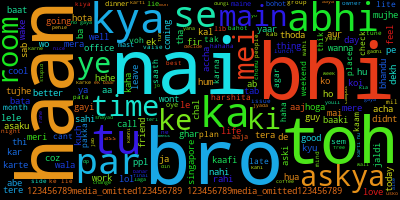

In [13]:
#Here is your wordCloud:
from IPython.display import Image
Image("./wordcloud.png")